In [1]:
# Final Models Visualization
# This notebook loads the final BERT and PyCaret models, evaluates them on a hold-out validation set (derived from `data/processed_train.csv`), and displays key statistics such as classification reports and confusion matrices.

# %% [code] {"execution":{"iopub.output_limit":false}}
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# For PyCaret model loading
from pycaret.classification import load_model

# For TF-IDF transformation and train/validation split
from tfidf_vectorizer import split_and_apply_tfidf

# For BERT model loading
from transformers import BertTokenizer, BertForSequenceClassification

In [2]:
# Set plotting style
plt.style.use('default')
%matplotlib inline

# Load Processed Training Data and Create Validation Split
# We use the `split_and_apply_tfidf` function to split the processed training data into training and validation sets. (For the BERT evaluation, we’ll use the raw text from the validation indices.)

# Load the processed training data
df = pd.read_csv("data/processed_train.csv")

In [3]:
# Use the same parameters as in the training scripts (e.g., max_features=1000, ngram_range=(1,1))
# Here we pass the same df as both train and test because our goal is to split for evaluation.
X_train_tfidf, X_val_tfidf, y_train, y_val = split_and_apply_tfidf(
    df, 
    df, 
    target="target", 
    text_column="clean_text", 
    max_features=1000, 
    ngram_range=(1, 1), 
    test_size=0.2, 
    random_state=42
)

Test TF-IDF features saved to 'data/processed_test_tfidf.csv'.


In [4]:
# Extract the raw validation texts (using the same indices as X_val_tfidf)
val_texts = df.loc[X_val_tfidf.index, "clean_text"].tolist()
val_labels = y_val.tolist()

print("Validation set size:", len(val_texts))


Validation set size: 1523


In [5]:
# ## Evaluate the BERT Model

# Load the saved BERT model and tokenizer
bert_model_path = "disaster_tweets_classification_best_bert_model"
tokenizer = BertTokenizer.from_pretrained(bert_model_path)
bert_model = BertForSequenceClassification.from_pretrained(bert_model_path)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

# Tokenize validation texts
val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_tensors="pt")


=== BERT Classification Report ===
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       874
           1       0.75      0.79      0.77       649

    accuracy                           0.80      1523
   macro avg       0.80      0.80      0.80      1523
weighted avg       0.80      0.80      0.80      1523



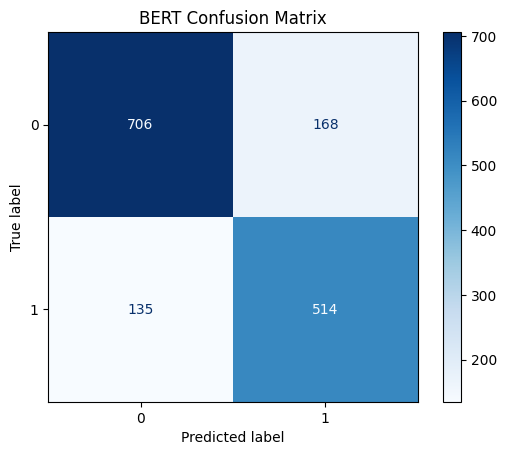

In [6]:
# Generate predictions with BERT
bert_model.eval()
with torch.no_grad():
    input_ids = val_encodings["input_ids"].to(device)
    attention_mask = val_encodings["attention_mask"].to(device)
    outputs = bert_model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    bert_preds = torch.argmax(logits, dim=1).cpu().numpy()

# Print classification report for BERT
print("=== BERT Classification Report ===")
print(classification_report(val_labels, bert_preds))

# Plot confusion matrix for BERT
cm_bert = confusion_matrix(val_labels, bert_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bert)
disp.plot(cmap=plt.cm.Blues)
plt.title("BERT Confusion Matrix")
plt.show()

Transformation Pipeline and Model Successfully Loaded
=== PyCaret Model Classification Report ===
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       874
           1       0.73      0.72      0.73       649

    accuracy                           0.77      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



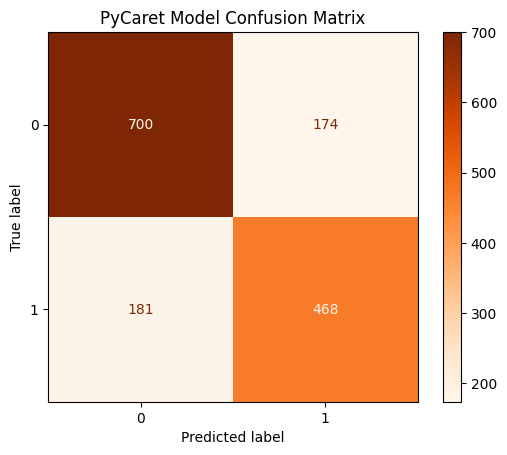

In [7]:
# ## Evaluate the PyCaret Mode

# Load the saved PyCaret model
pycaret_model = load_model("disaster_tweets_classification_best_pycaret_model")

# Use the validation TF-IDF features (X_val_tfidf) for prediction.
# Note: The PyCaret model was trained on the selected TF-IDF features.
pycaret_preds = pycaret_model.predict(X_val_tfidf)

# Print classification report for PyCaret model
print("=== PyCaret Model Classification Report ===")
print(classification_report(val_labels, pycaret_preds))

# Plot confusion matrix for PyCaret model
cm_pycaret = confusion_matrix(val_labels, pycaret_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_pycaret)
disp.plot(cmap=plt.cm.Oranges)
plt.title("PyCaret Model Confusion Matrix")
plt.show()